In [21]:
import sys
import os
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from itertools import chain
from scipy.interpolate import RegularGridInterpolator
from scipy.io import savemat
from eels_utils.ElectronSpectrum import ElectronSpectrum as es

In [22]:
Freq_Hz_To_MEEP = 3 * 10**14
Time_Sec_To_MEEP = (1e-6 / 3e8)
Time_MEEP_To_Sec = 1 / Time_Sec_To_MEEP

In [42]:
class ProblemSetup:

    def __init__(self, sx = None, sy = None, dpml = None, resolution = None):

        if sx is None:
            sx = 200
        if sy is None:
            sy = 50
        if dpml is None:
            dpml = 10
        if resolution is None:
            resolution = 5
            
        self._sx = sx
        self._sy = sy
        self._dpml = dpml
        self._resolution = resolution

def indium_arsenide():
    inas = {
        "n_exc_0" : 3.14e23,
        "n_eq" : 1.0e23,
        "gamma_p_sec_1" : 3.3e12, 
        "alpha" : 1.0/7,
        "epsilon_inf" : 12, 
        "epsilon_0" : 15,
        "omega_TO_cm_1" : 218, 
        "omega_LO_cm_1" : 240, 
        "gamma_ph_cm_1" : 3.5}
    return inas
    
def drude_material_meep(n_eq, gamma_p_sec_1, epsilon_inf):

    f_p = 20.7539 * np.sqrt(n_eq) / (2 * np.pi) / Freq_Hz_To_MEEP
    sigma_p = epsilon_inf
    gamma_p = gamma_p_sec_1 / (2 * np.pi) / Freq_Hz_To_MEEP

    return f_p, gamma_p, sigma_p

def lorentz_material_meep(omega_TO_cm_1, gamma_ph_cm_1, epsilon_0, epsilon_inf):

    f_ph = omega_TO_cm_1 * 3e10 / Freq_Hz_To_MEEP
    gamma_ph = gamma_ph_cm_1 * 3e10 / Freq_Hz_To_MEEP
    sigma_ph = epsilon_0 - epsilon_inf

    return f_ph, gamma_ph, sigma_ph

def current_rectification(sigma_t_sec, t0_sec, weight):
    
    t0 = t0_sec / Time_Sec_To_MEEP
    sigma_t = sigma_t_sec / Time_Sec_To_MEEP

    return lambda t: - weight * (t-t0) * np.exp(- ((t-t0) ** 2) / (2 * sigma_t **2))

def current_photodember(params, xprime, yprime):
    nexc = params['nexc_0'] * np.exp(-yprime * params['alpha']) * np.exp(-xprime**2 / (2 * params['sigma_spot']**2))

    omega_eq = 20.7539 * np.sqrt(params['neq'])
    omega_exc = 44.5865 * np.sqrt(nexc)
    omega_z_sec = np.sqrt(omega_exc**2 + omega_eq**2 - params['gamma']**2 / 4)
    omega_z = omega_z_sec / Freq_Hz_To_MEEP
    
    t0 = params['t0_sec'] / Time_Sec_To_MEEP
    gamma = params['gamma'] / Freq_Hz_To_MEEP
    return lambda t: nexc * np.sin(omega_z * (t-t0)) * np.exp(- gamma * (t-t0)/2) / omega_z if t>t0 else 0


def photodember_source(params, xmax, ymax):
    sl = [[mp.Source(
        src=mp.CustomSource(src_func=current_photodember(params, xi, yi)),
        center=mp.Vector3(xi,-yi),
        component=mp.Ey) for xi in np.linspace(0,xmax,1)] for yi in np.linspace(0,ymax,1)]
    return list(chain(*sl))


In [44]:
outdir = 'saved_matrices/photodember/'

Freq_Hz_To_MEEP = 3 * 10**14
Time_Sec_To_MEEP = (1e-6 / 3e8)
Time_MEEP_To_Sec = 1 / Time_Sec_To_MEEP

sx = 200
sy = 50
dpml = 10
resolution = 5


     block, center = (0,-17.5,0)
          size (1e+20,35,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)


          dielectric constant epsilon diagonal = (12,12,12)


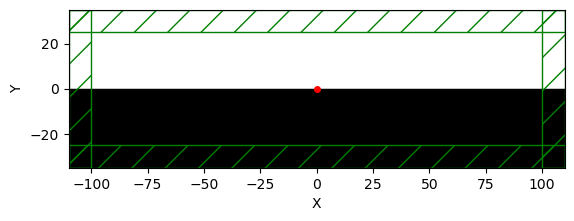

In [45]:

inas = indium_arsenide()
f_p, gamma_p, sigma_p = drude_material_meep(inas['n_eq'], inas['gamma_p_sec_1'], inas['epsilon_inf'])
f_ph, gamma_ph, sigma_ph = lorentz_material_meep(inas['omega_TO_cm_1'], 
inas['gamma_ph_cm_1'], inas['epsilon_0'], inas['epsilon_inf'])

sus_plasma = mp.DrudeSusceptibility(frequency=f_p, sigma=sigma_p, gamma=gamma_p)
sus_phonon = mp.LorentzianSusceptibility(frequency=f_ph, sigma=sigma_ph, gamma=gamma_ph)
inas_meep = mp.Medium(epsilon=inas['epsilon_inf'], E_susceptibilities=[sus_phonon, sus_plasma])

params = {
    't0_sec': 0.2e-12,
    'weight': 1,
    'alpha': inas['alpha'],
    'sigma_spot': 10,
    'neq': inas['n_eq'],
    'nexc_0': inas['n_exc_0'],
    'gamma': inas['gamma_p_sec_1']
}

xmax = 2 * params['sigma_spot']
ymax = 3 * (1 / params['alpha'])
source_pd = photodember_source(params, xmax, ymax)

geometry = [
mp.Block(
    mp.Vector3(mp.inf, sy/2 + dpml, mp.inf),
    center=mp.Vector3(0,-sy/4 - dpml/2),
    material=inas_meep,
)]

sim_pd = mp.Simulation(
    cell_size=mp.Vector3(sx + 2 * dpml, sy + 2 * dpml),
    boundary_layers=[mp.PML(dpml)],
    geometry=geometry,
    sources=source_pd,
    resolution=resolution,
    symmetries=None,
    progress_interval = 15
)

%matplotlib inline
plt.figure(dpi=100)
sim_pd.plot2D()
plt.show()


In [26]:
source_pd

     block, center = (0,-17.5,0)
          size (1e+20,35,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


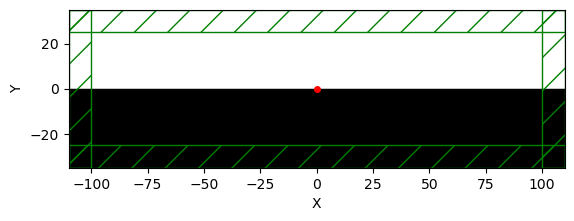

In [46]:


record_interval = 2
distance_from_surface = 1
simulation_end_time_meep = 500

%matplotlib inline
plt.figure(dpi=100)
sim_pd.plot2D()
plt.show()

# (x,y,z,w)=sim_pd.get_array_metadata(center=mp.Vector3(0,1), size=mp.Vector3(sx,0))


In [28]:
vals_pd = []
def get_slice(vals, distance_from_surface):
        return lambda sim : vals.append(sim.get_array(center=mp.Vector3(0,distance_from_surface), size=mp.Vector3(sx,0), component=mp.Ex))

record_interval = 2
distance_from_surface = 1
simulation_end_time_meep = 500

sim_pd.reset_meep()
sim_pd.run(mp.at_every(record_interval, get_slice(vals_pd, distance_from_surface)),
        until=simulation_end_time_meep)

-----------
Initializing structure...
time for choose_chunkdivision = 0.0005182 s
Working in 2D dimensions.
Computational cell is 220 x 70 x 0 with resolution 5
     block, center = (0,-17.5,0)
          size (1e+20,35,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.669235 s
drude susceptibility: frequency=0.00348176, gamma=0.0017507
lorentzian susceptibility: frequency=0.0218, gamma=0.00035
-----------
on time step 353 (time=35.3), 0.0113448 s/step
on time step 714 (time=71.4), 0.0111083 s/step
on time step 1073 (time=107.3), 0.0111719 s/step
Meep progress: 133.9/500.0 = 26.8% done in 15.0s, 41.0s to go
on time step 1431 (time=143.1), 0.0112033 s/step
on time step 1790 (time=179), 0.0111507 s/step
on time step 2148 (time=214.8), 0.0111826 s/step
on time step 2507 (time=250.7), 0.0111551 s/step
Meep progress: 268.1/500.0 = 53.6% done in 30.0s, 26.0s to go
on time step 2864 (time=286.4), 0.0112243 s/ste

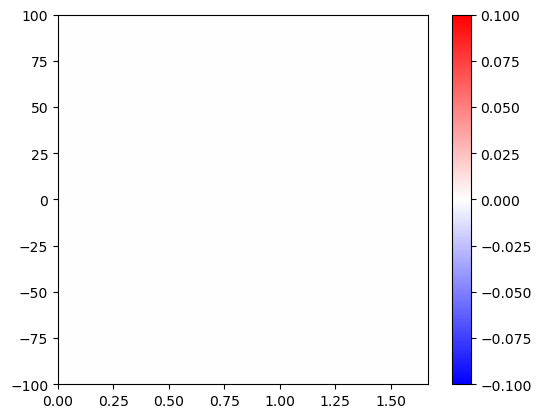

0.0

In [29]:
time_range = simulation_end_time_meep / Time_MEEP_To_Sec * 1e12

plt.figure()
val_np = np.array(vals_pd)
mm = np.max(val_np)
plt.imshow(val_np.T, 
           cmap='bwr',
           aspect = time_range / sx,
           extent = [0,time_range,-sx/2,sx/2])
# plt.clim(vmin=-mm, vmax=mm)
plt.colorbar()
plt.show()

mm

In [30]:
np.max(val_np)

0.0

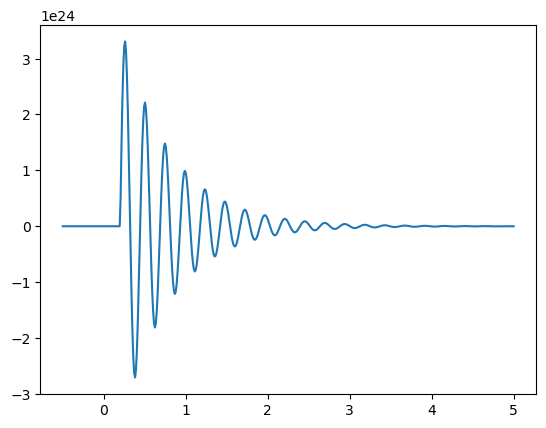

In [43]:
# current_photodember(params, xi, yi)

tt = np.linspace(-0.5e-12/ Time_Sec_To_MEEP,5e-12 / Time_Sec_To_MEEP,500)
current = list(map(current_photodember(params, 0, 0), tt))
plt.plot(tt / Time_MEEP_To_Sec * 1e12, current)
# plt.ylim(-5e24,5e24)

In [37]:
fc = current_photodember(params,0,0)
fc(5000)

-0.0